Here we add a causal convolution layer to the previous model.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
# load a list of popular names
words = open('names.txt','r').read().splitlines()
print(f'total of {len(words)} names')
words[:10]

total of 32033 names


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # get a sorted list of unique characters in words

# get a mapping of characters to their indices, then add start/end special token
s_to_i = {s : i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0 

# invert s_to_i
i_to_s = {i : s for s,i in s_to_i.items()}
vocab_size = len(s_to_i)
print(i_to_s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

def build_dataset(words, block_size = 3):
    
    # block_size is the context length: number of charachters we consider to predict the next one
    X, Y = [], []

    for w in words:
        context = [0] * block_size # create the sliding window, context filled with '.'

        # loop over charachters in the word w
        for char in w + '.':
            ix = s_to_i[char] # get the index of character char
            X.append(context) # add the 
            Y.append(ix) # add char index to the sequence
    #         print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix]) # print the context and the next character
            context = context[1:] + [ix] # crop the old context and add the next character
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(.8*len(words))
n2 = int(.9*len(words))

block_size = 12

# build train, validation and test datasets
X_train, Y_train = build_dataset(words[:n1], block_size = block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size = block_size)
X_test, Y_test = build_dataset(words[n2:], block_size = block_size)

torch.Size([182625, 12]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 12]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 12]) torch.int64 torch.Size([22866]) torch.int64


Here, we reuse the Bengio et. al. model as before with an embedding layer, a linear layer and a tanh nonlinear layer along with a batch normalisation layer. We modify the Flatten layer used in the previous model to give it structure of a causal convolution. 

In [6]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, ix):
        self.out = self.weight[ix] 
        return self.out
  
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    # flattens n consecutive elements and puts them into the last dimension
    def __init__(self, n):
        self.n = n  
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T //self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Linear:
    # Linear transformation neural layer
    def __init__(self, n_in, n_out, bias = True):
        self.weight = torch.randn((n_in, n_out)) / n_in**.5 # Kaiming initialisation
        self.bias = torch.zeros(n_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight 
        
        if self.bias is not None:
            self.out += self.bias
            
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class Tanh:
    # tanh non-lineraity layer
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class BatchNorm1d:
    # batch normalisation layer
    
    def __init__(self, dim, eps = 1e-05, momentum = .1):
        
        self.eps = eps
        self.momentum = momentum
        self.training = True # distinguish between batchnorm for training and for evaluation modes
        
        # parameter trained with backpropogation
        self.gamma = torch.ones(dim) # scale parameter
        self.beta = torch.zeros(dim) # shift parameter
        
        # buffers trained with 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # forward pass
        if self.training == True:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            x_mean = x.mean(dim, keepdim = True) # use batch mean
            x_var = x.var(dim, keepdim = True) # use batch variance
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        x_hat = (x - x_mean)/torch.sqrt(x_var + self.eps) # standardise
        self.out = self.gamma * x_hat + self.beta 
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        
    def __repr__(self):
        return f'Sequential model, number of layers: {len(self.layers)}, number of parameters: {sum([p.numel() for layer in self.layers for p in layer.parameters()])}'
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def add(self, layer):
        self.layers.append(layer)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

Let us further implement a dropout layer.

In [7]:
class Dropout:
    # Drop out layer   
    def __init__(self, p=0.5):
        self.p = p
        self.training = True

    def __call__(self, x):
        if not self.training or self.p == 0:
            return x
        mask = torch.empty_like(x).bernoulli_(1 - self.p)
        self.out = x * mask / (1 - self.p)
        return self.out
    
    def parameters(self):
        return []

In [8]:
torch.manual_seed(42)
n_embd = 16
n_hidden = 500

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(3), Linear(n_embd * 3, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Dropout(), Tanh(),
    Linear(n_hidden, vocab_size)]) 

print(f'number of parameters: { sum([p.numel() for layer in model.layers for p in layer.parameters()])}')
with torch.no_grad():
    model.layers[-1].weight *= .1
    
for p in model.parameters(): 
    p.requires_grad = True

number of parameters: 1040959


In [9]:
lossi = []
batch_size = 32

In [10]:
torch.manual_seed(42)
def train(X, Y, n_epochs = 200000, lr = .1):
    for i in range(n_epochs):
        # minibatch construct
        ix = torch.randint(0, X_train.shape[0], (batch_size,))
        X_batch, Y_batch = X_train[ix], Y_train[ix]
        
        # forward pass
        logits = model(X_batch)
        loss = F.cross_entropy(logits, Y_batch) # compute the loss
        
        # backward pass
        for p in model.parameters():
            p.grad = None

        loss.backward()
        
        # update
        lr = lr if i < int(n_epochs/1.5) else lr/10 # lower learning rate for the end of training
        
        for p in model.parameters():
            p.data += -lr * p.grad
            
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{n_epochs:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    print(f'{n_epochs:7d}/{n_epochs:7d}: {loss.item():.4f}')
    

In [11]:
n_epochs = 200000

train(X_train, Y_train, n_epochs = n_epochs)

      0/ 200000: 3.3030
  10000/ 200000: 2.0767
  20000/ 200000: 1.9178
  30000/ 200000: 2.0504
  40000/ 200000: 1.9045
  50000/ 200000: 1.6902
  60000/ 200000: 1.9167
  70000/ 200000: 2.3792
  80000/ 200000: 1.8360
  90000/ 200000: 1.5887
 100000/ 200000: 1.7780
 110000/ 200000: 2.2002
 120000/ 200000: 1.9987
 130000/ 200000: 2.1432
 140000/ 200000: 1.8224
 150000/ 200000: 1.5881
 160000/ 200000: 1.5751
 170000/ 200000: 1.5816
 180000/ 200000: 2.2491
 190000/ 200000: 1.9832
 200000/ 200000: 1.5757


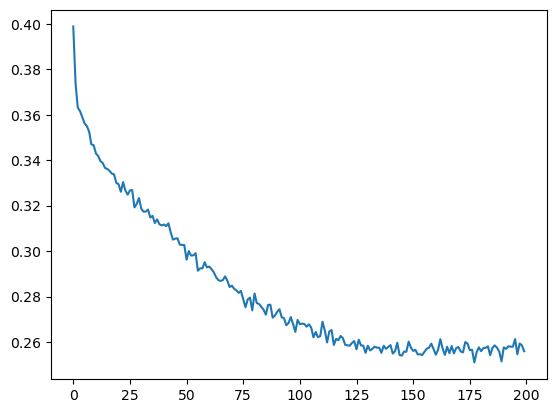

In [12]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [13]:
for layer in model.layers:
    print(layer.__class__.__name__,':', tuple(layer.out.shape))

Embedding : (32, 12, 16)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 500)
BatchNorm1d : (32, 4, 500)
Tanh : (32, 4, 500)
FlattenConsecutive : (32, 2, 1000)
Linear : (32, 2, 500)
BatchNorm1d : (32, 2, 500)
Tanh : (32, 2, 500)
FlattenConsecutive : (32, 1000)
Linear : (32, 500)
BatchNorm1d : (32, 500)
Dropout : (32, 500)
Tanh : (32, 500)
Linear : (32, 27)


In [14]:
for layer in model.layers:
    layer.training = False

In [15]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
split_loss('train')
split_loss('val')
split_loss('test')

train 1.7675418853759766
val 2.075198173522949
test 2.0703155994415283


In [16]:
torch.manual_seed(42)
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
      # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
      # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(i_to_s[i] for i in out)) # decode and print the generated word

yansy.
kaviah.
kellen.
saleigh.
brexlee.
arhen.
enderlyn.
jian.
abkella.
ashano.
zaeven.
margoe.
keeza.
korran.
rumen.
nacelyn.
anari.
zeriah.
tanna.
daumoni.
